# 📖 [LMX Tutorial] Absolute and Relative motion (in C++)

Based on the following WMX API document:

http://download.movensys.com:8222/doc/wmx3/en/html/api/page_WMXDOC_TUTORIAL_SEC3_1_ABS_REL.html

## 📢Important note
### 1. Using Coding Assistant 🪄
To show the documentation and members of the class and structure, press the `Ctrl` key on the highlighted code and the `Tab` key, respectively.

It's important to write C++ code in *__functions__* to help the coding assistant work properly.

### 2. About xeus-cling
A Jupyter kernel for C++ based on the `cling` C++ interpreter and the `xeus` native implementation of the Jupyter protocol, xeus.

To understand how the xeus-clang works, please try to run the following sample notebook provided by xeus-cling in advance.
Link to [xeus-cling notebook sample](xeus-cling-notebooks/xcpp.ipynb)


### ⭐ Include the following LMX cling header file to use WMX libraries

In [1]:
// This header lets cling knows how to load WMX3 API libraries
#include <lmx/lmx_cling_config.hpp>

## Import WMX library and declare WMX3 variables

Note that a utility class called `WmxUtil` is instantiated here.

In [2]:
// Include this utility header where includes WMX3 headers as well as some utility functions
#include "WMX3UtilClang.hpp"

// When all the devices are done, the WMX3 engine will also terminate.
WMX3Api wmx3Lib;
CoreMotionStatus cmStatus;
CoreMotion wmx3LibCore(&wmx3Lib);

// Initialize WMX3 Clang Utility
wmxclang::WmxUtil wmx3ClangUtil(&wmx3Lib);

// Declare global variables used in subsequent code
int     ret;
char    errString[256];
Motion::PosCommand pos;

A WmxUtil instance is created.


## WMX initialze: Set the device name and start communication

In [3]:
void initializeWMX() 
{
    std::cout << "Program Starts..." << std::endl;
    
    // Create device.
    ret = wmx3Lib.CreateDevice("/opt/lmx/", DeviceType::DeviceTypeNormal, INFINITE);
    if (ret != ErrorCode::None) {
        std::cerr << "Failed to execute CreateDevice. Error=" << ret << std::endl;
        throw std::runtime_error("WMX API exception");
    }
    
    std::cout << "CreateDevice succeeded!" << std::endl;

    // Set Device Name.
    wmx3Lib.SetDeviceName("MotorControl");
    if (ret != ErrorCode::None) {
        std::cerr << "Failed to execute SetDeviceName. Error=" << ret << std::endl;
        throw std::runtime_error("WMX API exception");
    }
    
    // Start Communication.
    wmx3Lib.StartCommunication(INFINITE);
    if (ret != ErrorCode::None) {
        std::cerr << "Failed to execute StartCommunication. Error=" << ret << std::endl;
        throw std::runtime_error("WMX API exception");
    }

    std::cout << "StartCommunication succeeded!" << std::endl;

    // Get DevicesInfo to determine the type of device currently created
    wmx3Api::DevicesInfoA devInfo;
    
    // Set wmx3Lib Name.
    ret = wmx3Lib.GetAllDevices(&devInfo);
    if (ret != ErrorCode::None) {
        std::cerr << "Failed to execute GetAllDevices. Error=" << ret << std::endl;
        throw std::runtime_error("WMX API exception");
    }
    
    std::cout << "Device Id : " << devInfo.devices[0].id << ", Name : " << devInfo.devices[0].name << std::endl;  
}

In [4]:
initializeWMX();

Program Starts...
CreateDevice succeeded!
StartCommunication succeeded!
Device Id : 0, Name : 


## WMX initialze: Get devices

## Set servo ON ▶️

In [5]:
void setServoOn(int axis, bool on) 
{
    // Set servo on or off.
    wmx3LibCore.axisControl->SetServoOn(axis, on);
    while (true)
    {
        wmx3LibCore.GetStatus(&cmStatus);
        if (cmStatus.axesStatus[axis].servoOn == on)
        {
            std::cout << "Servo axis : " << axis << ", on : " << on << " succeeded!" << std::endl;  
            break;
        }
    
        Sleep(100);
    }
}

In [6]:
setServoOn(0, true);

Servo axis : 0, on : 1 succeeded!


## 1. Absolute position command (`StartPos`)

Refer to the following API documentation:

http://download.movensys.com:8222/doc/wmx3/en/html/api/classwmx3_api_1_1_motion.html#_CPPv4N7wmx3Api6Motion8StartPosEjP17TriggerPosCommand

In [7]:
void doMotion(bool absolute, int vel, int acc, int dec, int target) 
{
    // Set position command parameters
    pos.axis = 0;
    pos.profile.type = ProfileType::Trapezoidal;
    pos.profile.velocity = vel;
    pos.profile.acc = acc;
    pos.profile.dec = dec;
    
    uint8_t logChannel = wmx3ClangUtil.startLog();
    if (logChannel < 0) {
        throw std::runtime_error("Failed to execute startLog");
    }
    
    // Execute absolute position command to 10000
    pos.target = target;
    if (absolute)
        ret = wmx3LibCore.motion->StartPos(&pos);
    else
        ret = wmx3LibCore.motion->StartMov(&pos);
    
    if (ret != ErrorCode::None) {
        wmx3LibCore.ErrorToString(ret, errString, sizeof(errString));
        std::cerr << "Failed to execute StartPos/StartMov. Error=" << ret << " (" << errString << ")" << std::endl;
        throw std::runtime_error("WMX API exception");
    }
    
    // Block execution until motion is finished
    ret = wmx3LibCore.motion->Wait(0);
    if (ret != ErrorCode::None) {
        wmx3LibCore.ErrorToString(ret, errString, sizeof(errString));
        std::cerr << "Failed to execute Wait. Error=" << ret << " (" << errString << ")" << std::endl;
        throw std::runtime_error("WMX API exception");
    }
    
    wmx3ClangUtil.pauseLog(logChannel);
}

In [12]:
// Arguments: Absolute, Velocity, Acc, Dec, Target
doMotion(true, 2000, 500, 500, 10000); // Absolute

curChannel: 7
MemoryLog thread stopped.
LogDataHistory: 9000 entries, overflow: FALSE


### 1.1 Draw the position and velocity plots for relative motion 📈

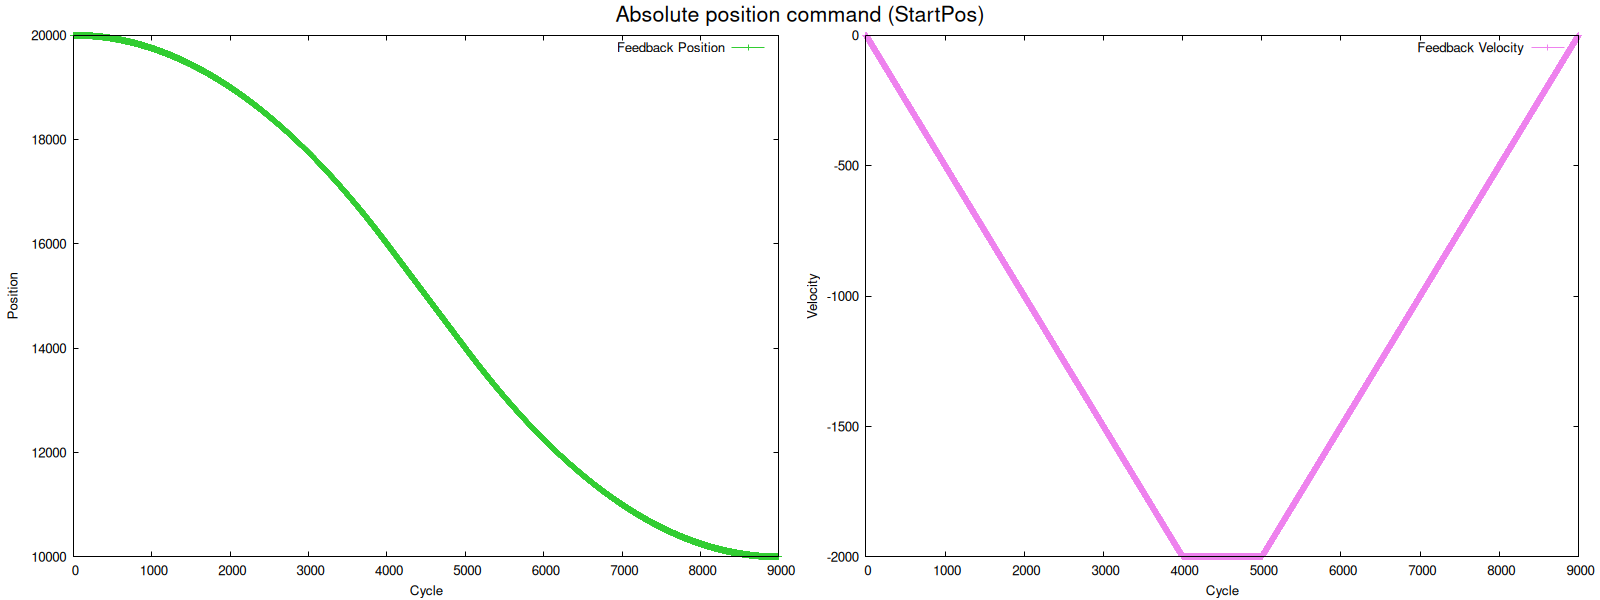

In [13]:
wmx3ClangUtil.drawPlots("Absolute position command (StartPos)", "startpos_result.png");
xcpp::clear_output(true);  // Clear output with preventing flickering
im::image logplot("startpos_result.png");
logplot

## 2. Relative position command (`StartMov`)

Refer to the following API documentation:

http://download.movensys.com:8222/doc/wmx3/en/html/api/classwmx3_api_1_1_motion.html#_CPPv4N7wmx3Api6Motion8StartMovEP10PosCommand

In [10]:
// Arguments: Absolute, Velocity, Acc, Dec, Target
doMotion(false, 2000, 500, 500, 10000); // Relative

curChannel: 7
MemoryLog thread stopped.
LogDataHistory: 9001 entries, overflow: FALSE


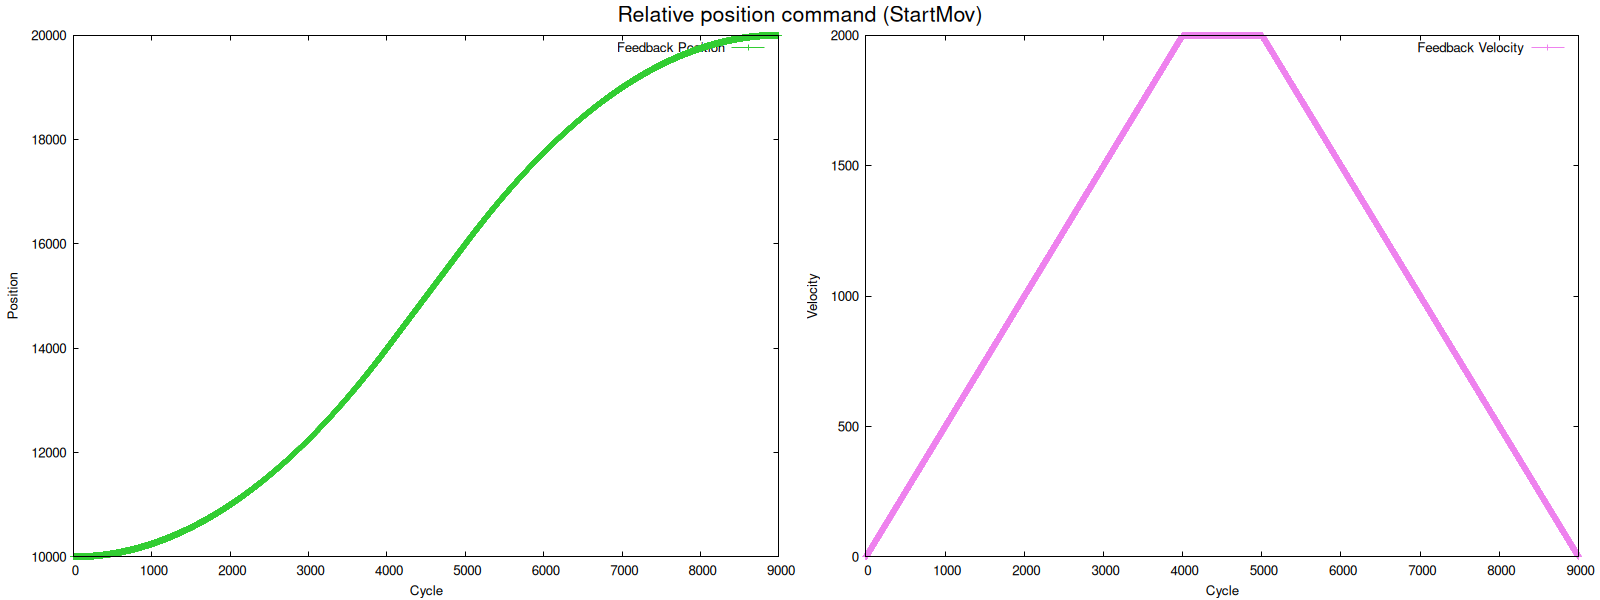

In [11]:
wmx3ClangUtil.drawPlots("Relative position command (StartMov)", "startmov_result.png");
xcpp::clear_output(true);  // Clear output with preventing flickering
im::image logplot("startmov_result.png");
logplot

### 1.1 Draw the position and velocity plots for relative motion 📈

## Set servo OFF ⏹️

In [ ]:
// Set servo off.
setServoOn(0, false);

## Stop communication and close the WMX3 API device

In [ ]:
void closeWMX() 
{
    // Stop Communication.
    wmx3Lib.StopCommunication(INFINITE);
    
    //close device.
    wmx3Lib.CloseDevice();
}

In [ ]:
closeWMX();